# Introduction to Machine Learning 
<center> Compiled by: </center>
<center> Ibrahim O. Alabi and Evi Ofekeze (Computing PhD, Data Science, Boise State University) </center>

## Learning Objectives

1. Understand the goals and main concepts of a Machine Learning Algorithm
2. Prepare a SnowEx dataset for Machine Learning
3. Understand the fundamental types of and techniques in Machine Learning
4. Implement Machine Learning with a SnowEx dataset

## What is Machine Learning?

Machine Learning simply means building algorithms or computer models using data. The goal is to use these "trained" computer models to make decisions. 

Here is a general definition;

> Machine Learning is the field of study that gives computers the ability to learn without being explicitly programmed (Arthur Samuel, 1959)

Over the years, ML algorithms have achieved great success in a wide variety of fields. Its success stories include disease diagnostics, image recognition, self-driving cars, spam detectors, and handwritten digit recognition. In this tutorial we will train a model using a SnowEx dataset.

### Binary Example

Suppose we want to build a computer model that returns 1 if the input is a prime number and 0 otherwise. This model may be represented as follows;

$$Y = F(X)$$

Where:

   * $X \to$ the number entered also called a feature
   * $Y \to$ the outcome we want to predict
   * $F \to$ the model that gets the job done

Contrary to classical programming where we the program function, in Machine Learning we learn the function by training the algorithm with data. 

<img src="images/ml.jpeg" alt="Drawing" style="width: 500px;"/>


$\qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad$ image by [Kpaxs on Twitter](https://twitter.com/Kpaxs/status/1163058544402411520)

Machine Learning is useful when the function cannot be programmed or the relationship between the features and outcome is unknown. 

## SnowEx Data

Now we will import data from the 2017 SnowEx Airborne Campaign. In Machine Learning terminologies, it contains the following features;

- phase
- coherence
- amplitude
- incidence angle

and outcome

- snow depth

The goal is to use the data to learn the computer model $F$ so that

snow depth = $F$(phase, coherence, amplitude, incidence angle) 

Once $F$ is learned, it can be used to predict snow depth given the features.

## Load Dataset

Note that this dataset has been cleaned in a separate notebook, and it is available for anyone interested.

Load libraries:

In [155]:
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [138]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error

In [9]:
dataset = pd.read_csv("data/snow_depth_data.csv")
dataset.info()
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   amplitude   3000 non-null   float64
 1   coherence   3000 non-null   float64
 2   phase       3000 non-null   float64
 3   inc_ang     3000 non-null   float64
 4   snow_depth  3000 non-null   float64
dtypes: float64(5)
memory usage: 117.3 KB


,amplitude,coherence,phase,inc_ang,snow_depth
0,0.198821,0.866390,-8.844648,0.797111,0.969895
1,0.198821,0.866390,-8.844648,0.797111,1.006760
2,0.212010,0.785662,-8.843649,0.799110,1.033615
3,0.212010,0.785662,-8.843649,0.799110,1.043625
4,0.173967,0.714862,-8.380865,0.792508,1.593430


## Train and Test Sets

For the algorithm to learn the relationship pattern between the feature(s) and the outcome variable, it has to be exposed to examples. The dataset containing the examples for training a learning machine is called the *train set* ($\mathcal{D}^{(tr)}$). 

On the other hand, the accuracy of an algorithm is measured on how well it predicts the outcome of observations it has not seen before. The dataset containing the observations not used in training the ML algorithm is called the *test set* ($\mathcal{D}^{(te)}$). 

In practice, we divide our dataset into train and test sets, train the algorithm on the train set and evaluate its performance on the test set.

In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the Data

**Visualization**

Before modelling, it is always a good idea to visualize our dataset. With visualization, we gain insights into the relationships between the variables and the shape of the distribution of each variable. For this data, we shall look into the scatterplot matrix.

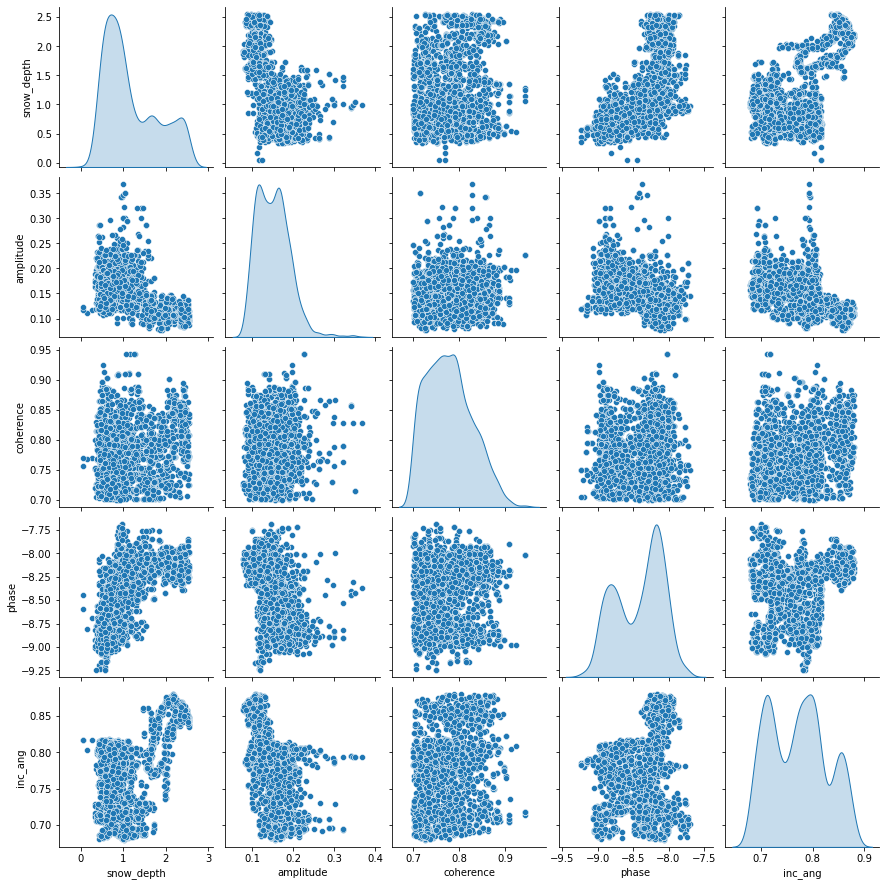

In [12]:
sns.pairplot(train_dataset[['snow_depth','amplitude', 'coherence', 'phase', 'inc_ang']], diag_kind='kde');

Each panel (excluding the main diagonal) of the scatterplot matrix is a scatterplot for a pair of variables whose identities are given by the corresponding row and column labels. The main diagonal is density plot for each variable. None of the features have a linear relationship with *snow_depth*. This may indicate that a linear model might not be the best option.

**Descriptive Statistics**

- count: the size of the training set
- mean: arithmetic mean
- std: sample standard deviation
- min: minimum value
- 25%: 25% of the values fall below this number
- 50%: 50$^{th}$ percentile also called the median. 50% of the values fall below this number and 50% of the values fall above this number
- 75%: 75% of the values fall below this number
- max: maximum value

In [13]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
amplitude,2400.0,0.151192,0.040073,0.077860,0.119580,0.148579,0.175531,0.368253
coherence,2400.0,0.778119,0.048796,0.700428,0.738597,0.773580,0.811030,0.942499
phase,2400.0,-8.419475,0.338714,-9.240785,-8.743792,-8.326929,-8.145543,-7.690262
inc_ang,2400.0,0.772514,0.054758,0.679981,0.719910,0.775250,0.809429,0.880183
snow_depth,2400.0,1.178734,0.629103,0.051438,0.667404,0.961838,1.652085,2.551194


### Normalization

The features and outcome are measured in different units and hence are on different scales. Machine Learning algorithms are very sensitive and important information can be lost if they are not on the same scale. A simple way to address this is to project all the variables onto the same scale, in a process known as **Normalization**.

Normalization simply consists of transforming the variables such that all values are in the unit interval [0, 1]. With Normalization, if $X_j$ is one of the variables, and we have $n$ observations $X_{1j}, X_{2j}, \cdots, X_{nj}$, then the normalized version of $X_{ij}$ is given by:

$$
\tilde{X}{ij} = \frac{X_{ij} - \min X_j}{\max X_j - \min X_j}
$$

In [66]:
scaler = MinMaxScaler()
scaled_train_features = scaler.fit_transform(train_dataset.drop(columns=['snow_depth']))
scaled_test_features = scaler.transform(test_dataset.drop(columns=['snow_depth'])) ## fit_transform != transform. 
                                                                                   ## transform uses the parameters of fit_transform

### Separate Features from Labels

Our last step for preparing the data for Machine Learning is to separate the features from the outcome.

In [67]:
train_X, train_y = scaled_train_features[:, :-1], train_dataset['snow_depth']
test_X, test_y = scaled_test_features[:, :-1], train_dataset['snow_depth']

## Why Estimate $F$?

We estimate $F$ for two main reasons;

1. Prediction: in this case, the features $X$ are available, but there is no explicit rule for obtaining the outcome $Y$.
2. Inference: in practice, we are sometimes interested in how changing the input $X$ effects $Y$. Inference can tell us which features are significantly associated with a paticular outcome and the nature of the relationship between $X$ and $Y$.
    

## How Do We Estimate $F$?

### Machine Learning Algorithms

Machine learning algorithms can be categorized based on different criteria. In this tutorial, our categorization will be based on the amount and type of supervision needed during the training process. Based on this criterion, there are four major categories; supervised learning, unsupervised learning, semisupervised learning, and reinforcement learning. We shall limit our definition to the first two;

* **Supervised Learning**: this refers to tasks where we have a specific outcome to predict. That is, every observation of the features has a corresponding outcome. An example of a supervised learning task is predicting snow depth based on some influencing features.
	 
* **Unsupervised Learning**: this refers to tasks where we have no outcome to predict.  Here, rather than predict an outcome, we seek to understand the relationship between the features or between the observations or to detect anomalous observations. Considering the example above, we assume the snow depth variable does not exist and we either understand the relationship between the features or between the observations based on the features.


It is worth noting that a variable can either be categorical or continuous. For now, let's focus on the nature of the outcome variable. In *Supervised Learning* parlance, if the outcome variable is categorical, we have a *classification* task and if continuous, we are in the presence of a *regression* task. Categorical implies that the variable is made of distinct categories (e.g. hair color: grey, blonde, black) and continuous implies that the variable is measured (e.g. snow depth). For the rest of this tutorial, we will focus on *Supervised Learning* tasks with a special concentration on regression tasks.


## Machine Learning Installation Guide

For this notebook to run successfully, you have to install the following packages;

1. TensorFlow
2. Keras

**Tensorflow**: it is an end-to-end open source platform for machine learning. It makes it easy to train and deploy machine learning models. TensorFlow was created at Google and supports many of their large-scale Machine Learning applications. Read more at [About TensorFlow](https://www.tensorflow.org/).

**Keras:**  Keras is a deep learning Application Programming Interface (API) written in Python, running on top of the machine learning platform TensorFlow. It was developed with a focus on enabling fast experimentation. Read more at [About Keras](https://keras.io/about/).

Other packages needed come pre-installed in Anaconda.

You only need to install TensorFlow as Keras comes as a submodule in TensorFlow. To install TensorFlow, launch the **Jupyter Lab Terminal** and type the following command:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  $\texttt{C:\Users\Default> pip install tensorflow}$

After installation, you will be able to continue with the tutorial. For this tutorial, both Tensorflow and Keras used are version 2.8


Most Machine Learning techniques can be characterised as either *parametric* or *non-parametric*. 

**Parametric:** The parametric approach simplifies the problem of estimating $F$ to a parameter estimation problem. The disadvantage is that we assume a particular shape of $F$ that may not match the true shape of $F$. The major advantage of using parametric approach that when inference is the goal we can understand how changing $X_1, X_2, \cdots, X_k$ effects $Y$. A common parametric method is the Linear Regression.

**Non-parametric:** Non-parametric approaches do not assume any shape for $F$. Instead, they try to estimate $F$ that gets as close to the data points as possible. The disadvantage of non-parametric approaches is that they require extensive training observations to estimate $F$ accurately. Common examples of non-parametric methods include Random Forest, Neural Networks, and support vector machines.

In this tutorial, we will focus on non-parametric approaches with a specific concentration on Random Forest and Neural networks.

## Random Forest

Random forest is a simple but powerful algorithm that handles classification and regression tasks. The structural building blocks of Random Forest are decision trees; we will begin our explanation with decision trees. When we use decision trees for regression tasks, we call them regression trees; when we use decision trees for classification tasks, we call them classification trees. Subsequently, we use “regression trees” instead of “decision trees” because we will solve a regression problem in this tutorial.

### Regression Trees

Consider a dataset $\mathcal{D}_n = \left\lbrace (\textbf{x}_1, y_1), (\textbf{x}_2, y_2), \cdots, (\textbf{x}_n, y_n) \right\rbrace$ where $\textbf{x}_i^\top \equiv ({x}_{i1}, {x}_{i2}, \cdots, {x}_{ik})$ denotes the $k$-dimensional vector of features, and $y_i$ represents the corresponding outcome (continuous in this case).

The fundamental concept underlying regression trees is to split the feature space (set of possible values for the features) into two sub-regions. The sub-regions are further divided into two until a stopping criterion is reached. The predicted value of a given observation is the arithmetic mean of the training observations in the region it belongs.


## Performance Evaluation

Each time we estimate the true outcome ($Y$) using a trained ML algorithm ($F(X)$), the discrepancy between the observed and predicted must be quantified. The question is, how do we quantify this discrepancy? This brings the notion of **loss function**. 

*Loss Function* $\mathcal{L} (\cdot,\cdot)$ is a bivariate function that quantifies the loss (error) we sustain from predicting $Y$ with $F(X)$. Put another way, **loss function** quantifies how close the prediction $F(X)$ is to the ground truth $Y$.

* Regression Loss Function

There exists quite a number of ways for which the loss of a regression problem may be quantified. We now illustrate two of them;

1. 

$$
\mathcal{L} (Y,F(X)) = (Y - F(X))^2
$$

This is popularly known as the *squared error loss* and it is simply the square of the difference between the observed and the predicted values. The loss is squared so that the function reaches its minimum (convex).

2.

$$
\mathcal{L} (Y,F(X)) = |Y - F(X)|
$$

Another way to quantify regression loss is by taking the absolute value of the difference between the observed ($Y$) and the predicted ($F(X)$) values. This is called the L1 loss.

It is worth noting that the *loss function* as defined above corresponds to a single observation. However, in practice, we want to quantify the loss over the entire dataset and this is where the notion of **empirical risk** comes in. Loss quantified over the entire dataset is called the *empirical risk*. Our goal in ML is to develop an algorithm such that the *empirical risk* is as minimum as possible. *Empirical risk* is also called the *cost function* or the *objective function* we want to minimize.

* Regression Empirical Risk

$$
\widehat{\mathcal{R}}_n(F) = \frac{1}{n}\sum_{i=1}^n{\mathcal{L}(Y_i, F(X_i))}
$$

The empirical risk corresponding to the squared error loss is called "mean squared error", while the empirical risk corresponding to the L1 loss is called "mean absolute error". Other Regression Loss functions can be found at [Keras: losses](https://keras.io/api/losses/)

## Random Forest Setup

Load Random forest Libraries:

In [68]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV

### Regression Tree

In [69]:
tree = DecisionTreeRegressor(random_state=0, max_depth=2)  ## random_state=0 for reproducible results
tree.fit(train_dataset.drop(columns=['snow_depth']), 
         train_dataset['snow_depth'])

DecisionTreeRegressor(max_depth=2, random_state=0)

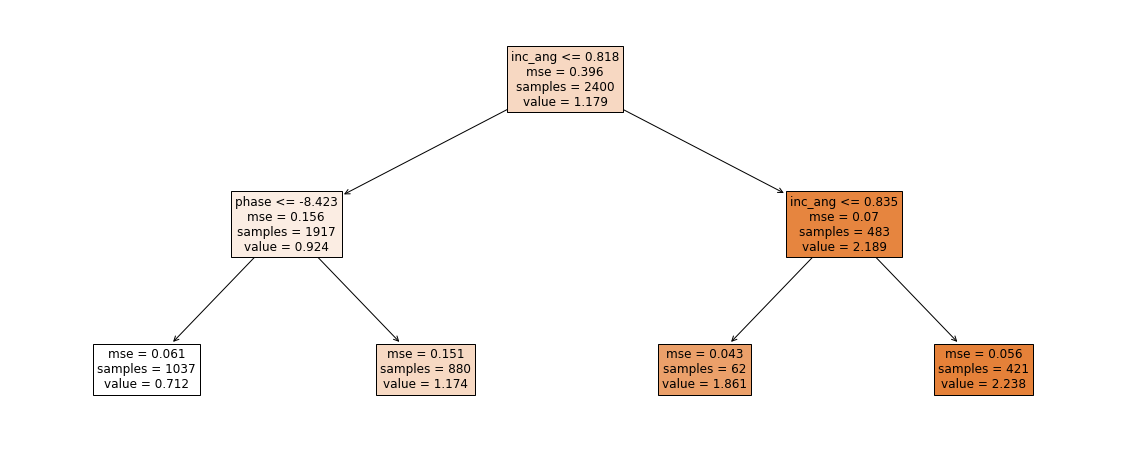

In [70]:
features = list(train_dataset.columns[:-1])

plt.figure(figsize = (20, 8))
plot_tree(tree, 
          filled = True, 
          fontsize = 12, 
         feature_names= features)
plt.show()

### Now let's explain the regression tree above

The root node assigns values of **incidence angle** lesser than or equal to 0.818 to the right branch and values of **incidence angle** greater than 0.818 to the left node. Observations with incidence angle lesser than or equal to 0.818 are further partitioned based on **phase** values. Overall, the regression tree splits the observations into four disjoint groups or regions ($R_i$) of the feature space.

\begin{align*}
R_1 &= \left\lbrace  X \ | \ \text{inc_angle} \le 0.818,\ \text{phase} \le -8.423 \right\rbrace \qquad \quad \hat{y}_{R_1} = 0.712 \\
R_2 &= \left\lbrace  X \ | \ \text{inc_angle} \le 0.818,\ \text{phase} > -8.423 \right\rbrace \qquad \quad \hat{y}_{R_2} = 1.174 \\
R_3 &= \left\lbrace  X \ | \ \text{inc_angle} > 0.818,\ \text{inc_angle} \le 0.835 \right\rbrace \qquad \hat{y}_{R_3} = 1.861 \\
R_4 &= \left\lbrace  X \ | \ \text{inc_angle} > 0.818,\ \text{inc_angle} > 0.835 \right\rbrace \qquad \hat{y}_{R_4} = 2.238 \\
\end{align*}

where $\hat{y}_{R_i}$ is the mean of the respective regions. The regions $R_i, \ i = 1,2,3, 4$ are called *terminal nodes* or *leaves*, the points where the feature space ($X$) is partitioned are called *internal nodes* and the line segments connecting the nodes are referred to as *branches*. Generally, to know which region an observation belongs to, we ask series of question(s) starting from the root node until we get to the terminal node and the value predicted for the observation is mean of all training observations in that region. Mathematically we write;
 \begin{equation}
 \hat{y} = \hat{f}(\text{x}) = \frac{1}{|R_j|} \sum_{i = 1}^{n} y_i 1(\text{x}_i \in R_j). 
 \end{equation}
 
Here, if the $i$th observation belongs to region $R_j$, the indicator function equals 1, else, it equals zero.

We have mentioned the recursive splitting of observations into regions, the natural question that comes
to mind is, how do we construct the regions? Our goal is to find regions such that the expected loss is minimized. To perform the recursive binary splitting, we consider all features in the feature space and all possible cut-point(s) for the individual features. The feature and cut-point leading to the greatest reduction in expected loss are chosen for splitting. This process is then continued until a stopping criterion is reached. A stopping criterion could be until no region contains more than five observations.

### How to make predictions

An example:

In [85]:
sample = test_dataset.loc[[0], ['amplitude', 'coherence', 'phase', 'inc_ang']]
sample

,amplitude,coherence,phase,inc_ang
0,0.198821,0.86639,-8.844648,0.797111


In [86]:
tree.predict(sample)

array([0.71192304])

* incidence angle is less than 0.818 and phase is lesser than -8.423. This falls in region two ($R_1$), and our prediction will be 0.712.

## Random Forest

> If you want to go fast, go alone. If you want to go far, go together (African Proverb).

Regression trees suffer from high variance, that is, they have a habit of overfitting the training observations. A straightforward way to reduce the variance is to employ the Random Forest (RF) algorithm. RF is an ensemble learning technique that can be used for both classification and regression. The term “ensemble learning” means combining multiple algorithms to obtain an improved version of the constituting algorithms. RF does this using the concept of Bagging.

* **Bagging:** Bagging consists of two words; Bootstrap and Aggregation. Bootstrap is a popular resampling technique where random sub-samples (with replacement) are created from the training data. The individual bootstrapped sub-sample is called a “Bag.” Aggregation, however, means combining the results from machines trained on the respective bags. We could say, given our training data, we generate $B$ bootstrapped training sub-samples from the original training data, then we train an algorithm on the respective bootstrapped sub-sample to obtain $\hat{F}^1 (\text{x}), \hat{F}^2 (\text{x}), \cdots , \hat{F}^B (\text{x})$. The final predicted value is the average of all the individual predictions and it is given by:
\begin{equation}
\hat{F}_{\text{bag}} (\text{x}) = \frac{1}{B} \sum_{b = 1}^{B} \hat{F}^{b} (\text{x}).
\end{equation}

This is bagging! In the RF algorithm, regression trees are built on the different bootstrapped samples and the result is a forest of regression trees, hence the "forest" in Random Forest. 

* What makes the forest random?

Recall that when training a regression tree, splitting is done at each internal node, however, in the RF algorithm, when building the individual regression trees, only a random sample of the total features is considered for optimal splitting and this is what makes the forest random! In essence, when we combine bagging with random feature selection at each internal node of the constituting regression trees, we are said to have constructed a **Random Forest** learning machine.

### Training Random Forest

In [39]:
rf = RandomForestRegressor(n_estimators=2,max_depth=2,random_state=0)

rf.fit(train_dataset.drop(columns=['snow_depth']), 
         train_dataset['snow_depth'])

RandomForestRegressor(max_depth=2, n_estimators=2, random_state=0)

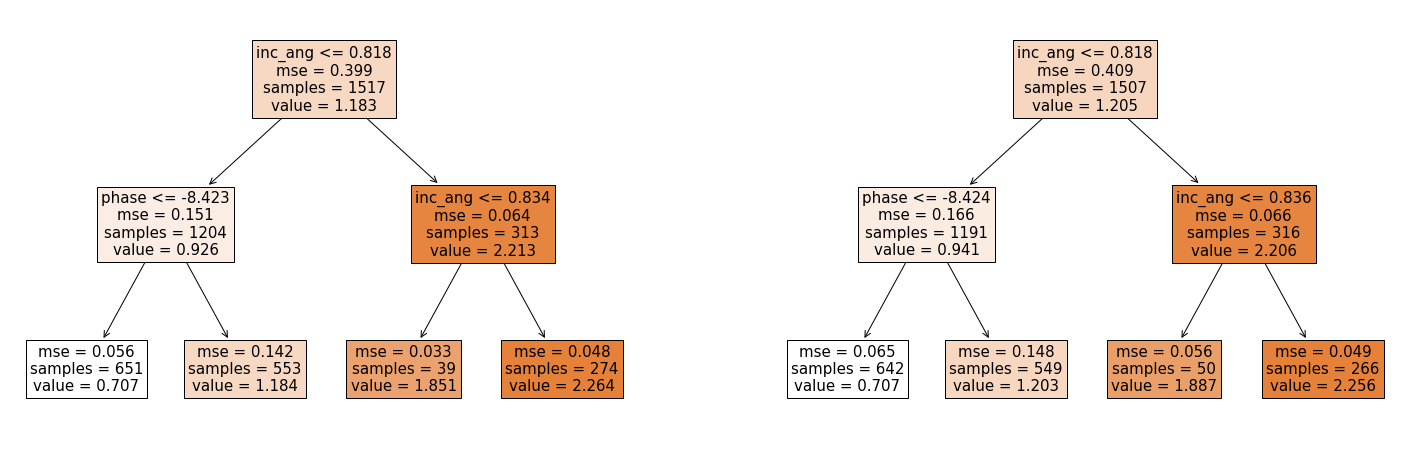

In [41]:
plt.figure(figsize = (25, 8))

plt.subplot(121)
plot_tree(rf.estimators_[0], 
          filled = True, 
          fontsize = 15, 
         feature_names= features)

plt.subplot(122)
plot_tree(rf.estimators_[1], 
          filled = True, 
          fontsize = 15, 
         feature_names= features)

plt.show()

### Making Predictions

In [92]:
sample

,amplitude,coherence,phase,inc_ang
0,0.198821,0.86639,-8.844648,0.797111


In [93]:
## Overall predictions

rf.predict(sample)

array([0.70685414])

In [94]:
## Prediction from the first tree

rf.estimators_[0].predict(sample)

array([0.70719868])

In [95]:
## Prediction from the second tree

rf.estimators_[1].predict(sample)

array([0.7065096])

Using the same approach as above, the first regression tree predicts 0.7072, and the second regression tree predicts 0.7065. Hence, the final prediction is;

$$\frac{0.7072+0.7065}{2} = 0.70685$$

### Feature Importance

The total amount by which the squared
error loss is decreased due to splits over a given predictor is documented and averaged over all trees in
the forest. The larger the value, the more important the variable.

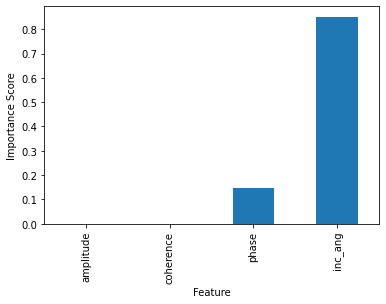

In [96]:
feature_impotanceRF = pd.Series(rf.feature_importances_, index=features)
feature_impotanceRF.plot(kind = 'bar')
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.show()

### Putting it all together

In [55]:
rf_pipe = Pipeline([
    ('Scaler', MinMaxScaler()),
    ('classifier', RandomForestRegressor())
])

rf_pipe.fit(train_dataset.drop(columns=['snow_depth']), 
         train_dataset['snow_depth'])

Pipeline(steps=[('Scaler', MinMaxScaler()),
                ('classifier', RandomForestRegressor())])

## Neural Networks

Neural networks (NN) are a type of non-parametric method. Non-parametric approaches do not assume any shape for $F$. Instead, the try to estimate $F$ that gets as close to the data points as possible. 

Neural networks are learning machines inspired by the functionality of biological neurons. They are not models of the brain, because there is no proven evidence that the brain operates the same way neural networks learn representations. However, some of the concepts were inspired by understanding the brain. Every NN consists of three distinct layers; 

1. Input layer 
2. Hidden layer(s) and 
3. Output layer. 

To understand the functioning of these layers, we begin by exploring the building blocks of neural networks; a single neuron or perceptron.

### A perceptron or Single Neuron

Each layer in a NN consists of small individual units called neurons (usually represented with a circle). A neuron receives inputs from other neurons, performs some mathematical operations, and then produces an output. Each neuron in the input layer represents a  feature. In essence, the number of neurons in the input layer equals the number of features. Each neuron in the input layer is connected to every neuron in the hidden layer. The number of neurons in the hidden layer is not fixed, it is problem dependent and it is often determined via cross-validation or validation set approach in practice. 

<img src="images/feedforward.png" alt="Drawing" style="width: 500px;"/>

The configuration of the hidden layer(s) controls the complexity of the network. A NN may contain more than one hidden layer. A NN with more than one hidden layer is called a **deep neural network** while that with a single hidden layer is a **shallow neural network**. The final layer of a neural network is called the output layer and it holds the predicted outcomes of observations passed into the input layer. Every inter-neuron connection has an associated weight, these weights are what the neural network learns during the training process. When connections between the layers do not form a loop, such networks are called **feedforward neural networks** and if otherwise, they are called **recurrent neural networks**. In this tutorial, we shall concentrate on the feed forward neural networks.



#### How the perceptron works

Consider a dataset $\mathcal{D}_n = \left\lbrace (\textbf{x}_1, y_1), (\textbf{x}_2, y_2), \cdots, (\textbf{x}_n, y_n) \right\rbrace$ where $\textbf{x}_i^\top \equiv ({x}_{i1}, {x}_{i2}, \cdots, {x}_{ik})$ denotes the $k$-dimensional vector of features, and $y_i$ represents the corresponding outcome. Given a set of input fed into the network through the input layer, the output of a neuron in the hidden layer is

$$
 f(\textbf{x}_i;\textbf{w}) = g(w_0 + \textbf{w}^\top \textbf{x}_i),
$$

where $\textbf{w} = (w_1, w_2, \cdots, w_k)^\top$ is a vector of weights and  $w_0$ is the bias term associated with the neuron. The weights can be thought of as the slopes in a linear regression and the bias as the intercept. The function $g(\cdot)$ is known as the activation function and it is  used to introduce non-linearity into the network.

<img src="images/perceptron.png" alt="Drawing" style="width: 400px;"/>

$\qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad$  A Perceptron

There exists a number of activation functions in practice, the commonly used ones are

1. Sigmoid or Logistic activation function $$g(z) = \frac{1}{1 + e^{-z}}.$$
2. Hyperbolic Tangent activation function $$g(z) = \tanh (z) = \frac{e^{z}-e^{-z}}{e^{z}+e^{-z}}.$$
3. Rectified Linear Unit activation function $$g(z) = \max(0,z).$$

### Visualizing Activation Functions

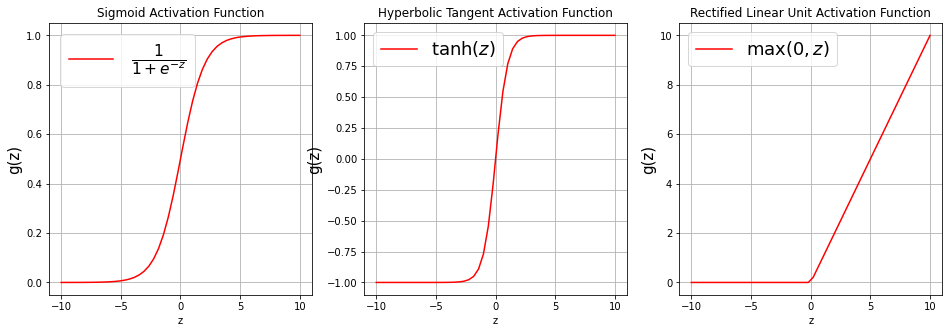

In [27]:
def Sigmoid(z):
    """
    A function that performs the sigmoid transformation
    
    Arguments:
    ---------
        -* z: array/list of numbers to activate
    
    Returns:
    --------
        -* logistic: the transformed/activated version of the array
    """
    
    logistic = 1/(1+ np.exp(-z))
    return logistic
    

def Tanh(z):
    """
    A function that performs the hyperbolic tangent transformation
    
    Arguments:
    ---------
        -* z: array/list of numbers to activate
    
    Returns:
    --------
        -* hyp: the transformed/activated version of the array
    """
    
    hyp = np.tanh(z)
    return hyp


def ReLu(z):
    """
    A function that performs the hyperbolic tangent transformation
    
    Arguments:
    ---------
        -* z: array/list of numbers to activate
    
    Returns:
    --------
        -* points: the transformed/activated version of the array
    """
    
    points = np.where(z < 0, 0, z)
    return points

z = np.linspace(-10,10)
fa = plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
plt.plot(z,Sigmoid(z),color="red", label=r'$\frac{1}{1 + e^{-z}}$')
plt.grid(True, which='both')
plt.xlabel('z')
plt.ylabel('g(z)', fontsize=15)
plt.title("Sigmoid Activation Function")
plt.legend(loc='best',fontsize = 22)


plt.subplot(1,3,2)
plt.plot(z,Tanh(z),color="red", label=r'$\tanh (z)$')
plt.grid(True, which='both')
plt.xlabel('z')
plt.ylabel('g(z)', fontsize=15)
plt.title("Hyperbolic Tangent Activation Function")
plt.legend(loc='best',fontsize = 18)

plt.subplot(1,3,3)
plt.plot(z,ReLu(z),color="red", label=r'$\max(0,z)$')
plt.grid(True, which='both')
plt.xlabel('z')
plt.ylabel('g(z)', fontsize=15)
plt.title("Rectified Linear Unit Activation Function")
plt.legend(loc='best', fontsize = 18)

### Families of Neural Networks

1. Feedforward Neural Networks: often used for structural data
2. Convolutional Neural Networks: the gold standard for image classification
3. Transfer Learning: reusing knowledge from previous tasks on new tasks
4. Recurrent Neural Networks: well suited for sequence data such as texts, time series, drawing generation
5. Encoder-Decoders: comminly used for but not limited to machine translation
6. Generative Adversarial Networks: usually used for 3D modelling for video games, animation, etc.
7. Graph Neural Networks: usually used to work with graph data.

## Neural Network Setup

Load libraries:

In [56]:
import tensorflow as tf # Keras is part of standard TensorFlow library (Keras is available as a submodule in the TensorFlow library)

In [57]:
### Check the version of Tensorflow and Keras
print("TensorFlow version ==>", tf.__version__) 
print("Keras version ==>",tf.keras.__version__)

TensorFlow version ==> 2.8.0
Keras version ==> 2.8.0


### Feedforward Neural Network

* **Specify Architecture**

Here, we shall include three hidden layers with 1000, 512, and 256 neurons respectively. Layers added using the "$\texttt{network.add($\cdots$)}$" command.

In [143]:
tf.random.set_seed(1000)  ## For reproducible results
network = tf.keras.models.Sequential() # Specify layers in their sequential order
# inputs are 4 dimensions (4 dimensions = 4 features)
# Dense = Fully Connected.   
# First hidden layer has 1000 neurons with relu activations.
# Second hidden layer has 512 neurons with relu activations
# Third hidden layer has 256 neurons with Sigmoid activations
network.add(tf.keras.layers.Dense(1000, activation='relu' ,input_shape=(train_X.shape[1],)))
network.add(tf.keras.layers.Dense(512, activation='relu')) # sigmoid, tanh
network.add(tf.keras.layers.Dense(256, activation='sigmoid'))
# Output layer uses no activation with 1 output neurons
network.add(tf.keras.layers.Dense(1)) # Output layer

* **Compile**

The learning rate controls how the weights and bias are optimized. A discussion of the optimization procedure for Neural Networks can be found in Appendix B. If the learning rate is too small the training may get stuck, while if it is too big the trained model may be unreliable.

In [144]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
network.compile(optimizer = opt, loss='mean_squared_error')

* **Print Architecture**

In [145]:
network.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1000)              4000      
                                                                 
 dense_13 (Dense)            (None, 512)               512512    
                                                                 
 dense_14 (Dense)            (None, 256)               131328    
                                                                 
 dense_15 (Dense)            (None, 1)                 257       
                                                                 
Total params: 648,097
Trainable params: 648,097
Non-trainable params: 0
_________________________________________________________________


Number of weights connecting the input and the first hidden layer = (1000 $\times$ 4) + 1000(bias) = 5000 

* 4 = $\texttt{number of features}$
* 1000 = $\texttt{number of nodes in the first hidden layer}$

Number of weights connecting the first hidden layer and the second hidden layer = (1000 $\times$ 512) + 512(bias) = 512512 

* 512 = $\texttt{number of nodes in the second hidden layer}$
* 1000 = $\texttt{number of nodes in the first hidden layer}$

Number of weights connecting the second hidden layer and the third hidden layer = (512 $\times$ 256) + 256(bias) = 131328 

* 256 = $\texttt{number of nodes in the third hidden layer}$
* 512 = $\texttt{number of nodes in the second hidden layer}$

Number of weights connecting the third (last) hidden and the output layers = (256 $\times$ 1) + 1(bias) = 257 

* 256 = $\texttt{number of nodes in the third hidden layer}$
* 1 = $\texttt{number of nodes in the output layer}$

* **Fit Model**

Here we find the neural network weights using the data in the training set. An epoch is when an entire batch of the training set has been used. The number of times we iterate over the dataset is known as the number of **epochs**. The validation split is the fraction of the training set that will be used to evaluate the loss at the end of each epoch.

In [146]:
start_time = time.time()
# NOTE: Change to verbose=1 for per-epoch output
history =network.fit(train_X, train_y, epochs=100, validation_split = 0.2, verbose=0)
print('Total time taken (mins): ', round(float((time.time()-start_time)/60),2))

Total time taken (mins):  0.38


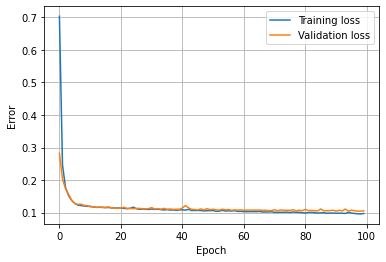

In [147]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

### Prediction

We have used Machine Learning to build two computer models $F$ with SnowEx data. Now we will use the computer models to estimate snow depth for a given set of features (phase, coherence, amplitude, incidence angle).

In [148]:
## Random Forest

yhat_RF = rf_pipe.predict(test_dataset.drop(columns=['snow_depth']))


## Feed Forward Neural Network
yhat_dnn = network.predict(test_X).flatten() 


## True Snow Depth (Test Set)
observed = test_dataset["snow_depth"].values


## Put Observed and Predicted (Linear Regression and DNN) in a Dataframe
prediction_df = pd.DataFrame({"Observed": observed,
                    "RF":yhat_RF, "DNN":yhat_dnn})

### Check Performance

In [149]:
def evaluate_model(y_true, y_pred, model_name, dp = 2):
    RMSE = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred)).round(dp)
    MAE  = mean_absolute_error(y_true=y_true, y_pred=y_pred).round(dp)
    MAPE = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred).round(dp)*100
    RSQ  = r2_score(y_true=y_true, y_pred=y_pred).round(dp)*100
    
    score_df = pd.DataFrame({
        model_name: [RMSE, MAE, MAPE, RSQ]
    }, index = ['RMSE(in)', 'MAE(in)', 'MAPE(%)', 'RSQ(%)'])
    
    return score_df

In [150]:
RF_evaluation=evaluate_model(prediction_df.RF, prediction_df.Observed, 'Random Forest')
NN_evaluation=evaluate_model(prediction_df.DNN, prediction_df.Observed, 'Random Forest')

comparison=pd.concat([RF_evaluation, NN_evaluation], axis=1)
comparison

,Random Forest,Random Forest
RMSE(in),0.17,0.34
MAE(in),0.11,0.24
MAPE(%),11.00,22.00
RSQ(%),92.00,66.00


### Visualize Performance

Text(0.5, 1.0, 'Deep Neural Network')

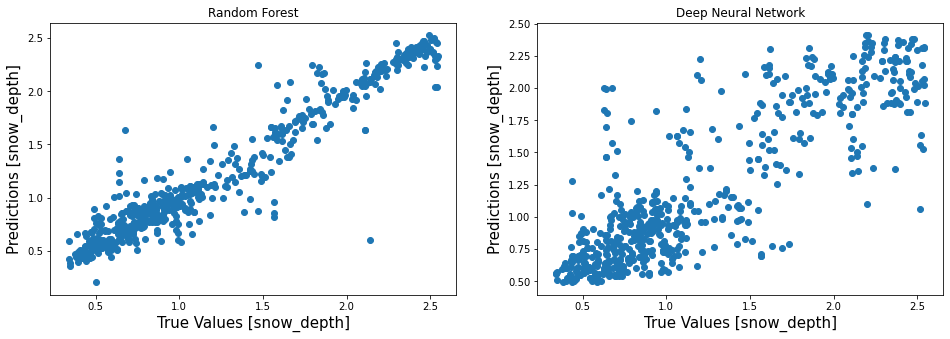

In [152]:
fa = plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.scatter(prediction_df['Observed'],prediction_df['RF'])
plt.xlabel('True Values [snow_depth]', fontsize=15)
plt.ylabel('Predictions [snow_depth]', fontsize=15)
plt.title("Random Forest")


plt.subplot(1,2,2)
plt.scatter(prediction_df['Observed'],prediction_df['DNN'])
plt.xlabel('True Values [snow_depth]', fontsize=15)
plt.ylabel('Predictions [snow_depth]', fontsize=15)
plt.title("Deep Neural Network")


### Visualize Error

Text(0.5, 1.0, 'Deep Neural Network')

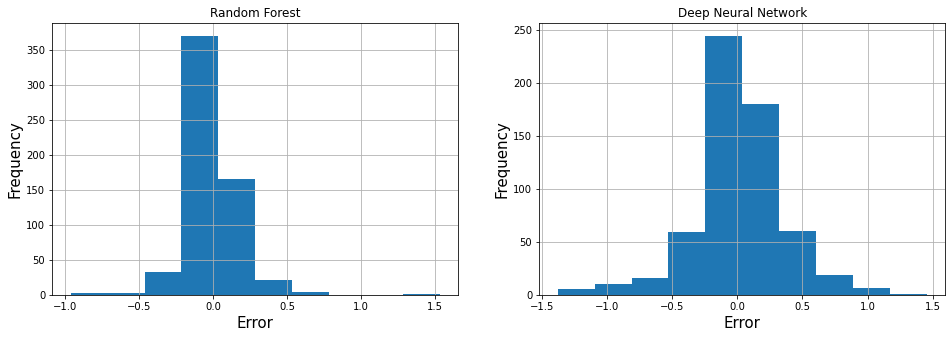

In [154]:
LR_error = prediction_df['Observed'] - prediction_df['RF']
DNN_error = prediction_df['Observed'] - prediction_df['DNN']

fa = plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
LR_error.hist()
plt.xlabel('Error', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title("Random Forest")

plt.subplot(1,2,2)
DNN_error.hist()
plt.xlabel('Error', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title("Deep Neural Network")

### Save Models

In [38]:
network.save('DNN')

## To load model, use;
model = tf.keras.models.load_model('DNN')

INFO:tensorflow:Assets written to: DNN/assets


### Main Challenges of Machine Learning

1. Bad Data (insufficient training data, nonrepresentative training data, irrelevant features)
2. Bad Algorithm (overfitting the training the data, underfitting the training data)

### Improving your Deep Learning Model

Here are some ways to improve your deep neural network;

1. Regularization (early stopping, dropout, etc)
2. Hyperparameter Optimization

## Optimizing Hyperparameters

content to be added soon...

## Your Turn (likely to change)

Using same dataset, fit a deep neural network with four hidden layers. Set a random seed of 200 for reproducible results. The number of neuron in the hidden layers should be 512, 256, 128, and 64 respectively. Use the "relu" activation for all hidden layers, optimize using the "mean_absolute_error", set your learning rate to 0.0005, and set your number of epochs to 50. 

1. Plot the training and validation loss. Compare to previous DNN model.
2. Use new DNN model to predict snow depth with the test data. Evaluate performance using RMSE, $R^2$, and MAPE. Compare to results from previous DNN model.
3. Plot predicted snow depth vs. the observed snow depth. Which DNN model do you think is most reliable?

## Acknowledgements

Content to be added soon...

## Reference

1. [Santiago on Twitter](https://twitter.com/svpino)
2. [A Taxonomy of Big Data for Optimal Predictive Machine Learning and Data Mining by Ernest Fokoue](https://arxiv.org/abs/1501.00604)
3. [An Introduction to Statistical Learning with Applications in R](https://link.springer.com/book/10.1007%2F978-1-4614-7138-7) (available online for free)
4. [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems 2nd Edition](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646)
5. [MIT 6.S191: Introduction to Deep Learning](https://www.youtube.com/channel/UCtslD4DGH6PKyG_1gFAX7sg)
6. [Intro to Deep Learning (ML Tech Talks)](https://www.youtube.com/watch?v=AhE8RhPGH1A&t=2685s)

## Appendix 
 content to be added soon...